# Load Packages

In [88]:
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# Basic Functions

In [89]:
def style_plot():
    """Goal:
        Apply the given style to the plot.
    """
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # Set linewidth of remaining spines to 2
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    # Remove ticks
    plt.tick_params(left = False, bottom = False)
    # Grid and legend
    plt.grid()
    plt.legend()

def sigmoid(x: float|np.ndarray[np.float64], vhalf: float, k: float
            ) -> float|np.ndarray[np.float64]:
    """Goal:
        Return the sigmoid function for a given x, vhalf, and k.
    --------------------------------------------------------------------
    Parameters:
        x: Membrane voltage [mV]
        vhalf: The half-maximum voltage [mV]
        k: The slope factor [mV]
    --------------------------------------------------------------------
    Returns:
        The sigmoid function for a given x, vhalf, and k.
    """
    return 1 / (1 + np.exp(-(x - vhalf) / k))


# Functions for the Markov Model

In [90]:
@njit(fastmath = True)
def transition_matrix(Vm: float) -> np.ndarray[np.float64]:
    """Goal:
        This function returns the transition matrix of the Markov model for the
        Kv11 channel at a given voltage Vm.
        
        Adapted from the KV11.1 Markov model described in:
            Mazhari R, Greenstein JL, Winslow RL, Marbán E, Nuss HB. 
            Molecular interactions between two long-QT syndrome gene products, 
            HERG and KCNE2, rationalized by in vitro and in silico analysis. 
            Circ Res. 2001 Jul 6;89(1):33-8. doi: 10.1161/hh1301.093633. 
            PMID: 11440975.
    ---------------------------------------------------------------------------
    Input:
        Vm: Membrane voltage [mV]
    ---------------------------------------------------------------------------
    Output:
        Q: Transition matrix of the Markov model [s^-1]"""
    # Transition rates [ms^-1]
    # 5 States; 3 closed (C1, C2, C3), a transition state (I) and an open state (O)
    # C1 - C2 - C3 - O
    #            \  /
    #              I    
    C1C2 = 0.0069 * np.exp(0.0272 * Vm) # Symbol in the paper --> a0
    C2C1 = 0.0227 * np.exp(-0.0431 * Vm) # b0
    C3O = 0.0218 * np.exp(0.0262 * Vm) # a1
    OC3 = 0.0009 * np.exp(-0.0269 * Vm) # b1
    OI = 0.0622 * np.exp(0.0120 * Vm) # ai
    IO = 0.0059 * np.exp(-0.0443 * Vm) # bi
    C2C3 = 0.0266 # kf
    C3C2 = 0.1348 # kb
    C3I = 1.29E-5 * np.exp(2.71E-6 * Vm) # ai3
    IC3 = (OC3 * IO * C3I) / (C3O * OI) # Greek letter

    # Transition matrix
    Q = np.zeros((5, 5), dtype = np.float64)
    Q[0, 0] = -C1C2 # C1
    Q[0, 1] = C2C1
    Q[1, 0] = C1C2 # C2
    Q[1, 1] = -(C2C1 + C2C3)
    Q[1, 2] = C3C2
    Q[2, 2] = -(C3C2 + C3O + C3I) # C3
    Q[2, 1] = C2C3
    Q[2, 3] = OC3
    Q[2, 4] = IC3
    Q[3, 3] = -(OC3 + OI) # O
    Q[3, 2] = C3O
    Q[3, 4] = IO
    Q[4, 4] = -(IO + IC3) # I
    Q[4, 2] = C3I 
    Q[4, 3] = OI
    
    return Q * 1000 # ms^-1 to s^-1


def steady_state(Vm: float) -> np.ndarray[np.float64]:
    """Goal:
        This function returns the steady state probabilities of the Markov model
        for the Kv11 channel at a given voltage Vm.
    ---------------------------------------------------------------------------
    Input:
        Vm: Membrane voltage [mV]
    ---------------------------------------------------------------------------
    Output:
        steady_state: Steady state probabilities of the Markov model
    """
    # Create transition matrix and adapt the last row in such a way that all
    # have weight 1
    Q = transition_matrix(Vm)
    Q[-1, :] = 1
    # Solve the linear system --> last equation ensures that sum of probabilities is 1
    b = np.array([0, 0, 0, 0, 1])
    steady_state = np.linalg.solve(Q, b)
    return steady_state

@njit(fastmath = True)
def kv11(t: np.float64, y: np.ndarray[np.float64], Vm: float) -> np.ndarray[np.float64]:
    """Goal:
        This function returns the derivative of the state probabilities of the
        Kv11 channel at a given voltage Vm.
    ---------------------------------------------------------------------------
    Input:
        t: Time [s]
        y: State probabilities of the Markov model
        Vm: Membrane voltage [mV]
    ---------------------------------------------------------------------------
    Output:
        dydt: Derivative of the state probabilities of the Markov model
    """
    Q = transition_matrix(Vm)
    return Q @ y


# Protocol 1: Measure Peak Tail Current's Voltage Dependence

In [ ]:
def get_peak_tail_currents(
        Vmclamp: float = -80.0, 
        Vmpres: np.ndarray[np.float64] = np.arange(-80, 61, 10),
        dpres: np.ndarray[np.float64] = np.array([3.5]),
        Vmtests: np.ndarray[np.float64] = np.array([-50]), 
        dtest: float = 0.5,
        dt = 0.0001,
        Ek: float = -82.0
        ) -> np.ndarray[float]:
    """Goal:
        This function returns the (peak) tail currents of the Kv11 channel for a
        given voltage clamp protocol. The protocol consists of a pre-pulse at
        Vmpre [mV] for 'dpre' seconds, followed by a test pulse at Vmtest [mV] for
        'dtest' seconds. The membrane voltage is clamped at Vmclamp [mV] before.
    ---------------------------------------------------------------------------
    Input:
        Vmclamp: Membrane voltage [mV]
        Vmpres: Voltage(s) of the pre-pulse [mV]
        dpres: Duration(s) of the pre-pulse [s]
        Vmtests: Voltage(s) of the test pulse [mV]
        dtest: Duration of the test pulse [s]
        dt: Time step [s]
        Ek: Potassium reversal potential [mV]
    ---------------------------------------------------------------------------
    Output:
        tail_currents: Tail currents of the Kv11 channel for the given voltage clamp
            protocol (vmpres, dpres, vmtests, dtest/dt).
        peak_tail_currents: Peak tail currents of the Kv11 channel for the given
            voltage clamp protocol (vmpres, dpres, vmtests).
    """
    # Set time [s] for the test pulse
    t_test_span = (0, dtest)
    t_test = np.arange(t_test_span[0], t_test_span[1], dt)

    # Get y0
    y0 = steady_state(Vmclamp)

    # Initialize arrays for tail currents and peak tail currents
    tail_currents = np.empty(
        (Vmpres.shape[0], dpres.shape[0], Vmtests.shape[0], int(dtest/dt))
        )
    peak_tail_currents = np.empty(
        (Vmpres.shape[0], dpres.shape[0], Vmtests.shape[0])
        )

    # Perform the simulation
    for iVmpre, Vmpre in enumerate(Vmpres):
        for idpre, dpre in enumerate(dpres):
            for iVmtest, Vmtest in enumerate(Vmtests):
                # Solve ODEs
                sol = solve_ivp(
                    kv11, (0, dpre), y0.copy(), args=(Vmpre,), 
                    t_eval = np.arange(0, dpre, dt), method='RK45'
                    )
                sol = solve_ivp(
                    kv11, t_test_span, sol.y[:, -1], args=(Vmtest,), 
                    t_eval = t_test, method='RK45'
                    )
                # Append the tail currents 
                tail_current = sol.y[3, :] * (Vmtest - Ek)
                tail_currents[iVmpre, idpre, iVmtest, :] = tail_current

                argabsmax = np.argmax(abs(tail_current))
                peak_tail_currents[iVmpre, idpre, iVmtest] = tail_current[argabsmax]

    return tail_currents, peak_tail_currents


C:\Users\niels\AppData\Local\Temp\ipykernel_19536\1384612279.py:91: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  return Q @ y
C:\Users\niels\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numba\core\typing\npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


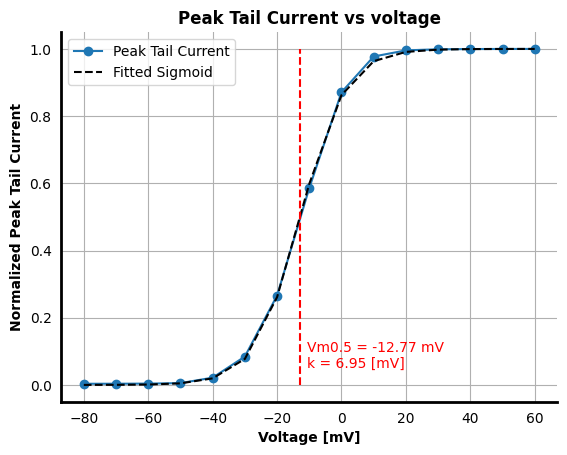

In [91]:
# ----- Parameters --> see function for more details
Vmclamp = -80.0 # [mV]
Vmpre = np.arange(-80, 61, 10) # [mV]
dpre = np.array([3.5]) # [s]
Vmtest = np.array([-50]) # [mV] 
dtest = 0.5 # [s]
dt = 0.0001 # [s]
Ek = -82.0 # [mV]

# Get peak tail currents
tail_currents, peak_tail_currents = get_peak_tail_currents(
    Vmclamp = Vmclamp, Vmpres = Vmpre, dpres = dpre, Vmtests = Vmtest, 
    dtest = dtest, dt = dt, Ek = Ek
    )
peak_tail_currents = peak_tail_currents[:, 0, 0]

# Fit sigmoid
popt, _ = curve_fit(sigmoid, Vmpre, peak_tail_currents / max(peak_tail_currents))

# Plot
plt.plot(Vmpre, peak_tail_currents / max(peak_tail_currents), 'o-', label = 'Peak Tail Current')
plt.plot(Vmpre, sigmoid(Vmpre, *popt), 'k--', label = 'Fitted Sigmoid')
plt.vlines(popt[0], 0, 1, 'r', '--')
plt.text(
    popt[0] + 2, 0.05, 
    f'Vm0.5 = {popt[0].round(2)} mV\nk = {popt[1].round(2)} [mV]', color = 'r'
    )

plt.xlabel('Voltage [mV]', fontweight = 'bold')
plt.ylabel('Normalized Peak Tail Current', fontweight = 'bold')
plt.title('Peak Tail Current vs voltage', fontweight = 'bold')
style_plot()
plt.show()

In the figure above we see the normalized peak tail current as a function of membrane voltage. We also observe the voltage of half activation (Vm0.5) and the slope (k). The blue dots indicate the modeled response, and the black dashed line indicates the sigmoid that is fitted to those modeled points. See figure 2A in the paper.

# Protocol 2: Activation Kinetics

In [125]:
def kinetics(duration: float, tau: float, d: float, peak_tail_currents: np.ndarray[np.float64],
            label: str = "activation kinetics"
            ) -> np.ndarray[np.float64]:
    """Goal:
        This functions returns the kinetics of the Kv11 channel for a given
        voltage clamp protocol.
    ---------------------------------------------------------------------------
    Input:
        duration: Duration of the test pulse [s]
        tau: Time constant [s]
        d: Delay [s]
        peak_tail_currents: Peak tail currents of the Kv11 channel for the given 
            voltage clamp protocol.
        label: "activation kinetics" or "deactivation kinetics".
    ---------------------------------------------------------------------------
    Output:
        Kinetics of the Kv11 channel for a given voltage clamp protocol."""

    if label == "activation kinetics":
        return peak_tail_currents * (1 - np.exp((-duration + d) / tau))
    elif label == "deactivation kinetics":
        return peak_tail_currents * np.exp((-duration + d) / tau)
    else:
        raise ValueError(f"Invalid label {label}.")

def get_tau(act_data: np.ndarray[np.float64], dpre: np.ndarray[np.float64],
            label: str = "activation kinetics", plot: bool = False
            ) -> np.ndarray[np.float64]:
    """Goal:
        This function returns the time constants of the kinetics of the Kv11
        channel for a given voltage clamp protocol.
    ---------------------------------------------------------------------------
    Input:
        act_data: Peak tail currents of the Kv11 channel for the given voltage 
            clampprotocol.
        dpre: Duration(s) of the pre-pulse [s]
        label: "activation kinetics" or "deactivation kinetics".
        plot: If True, plot the kinetics of the Kv11 channel.
    ---------------------------------------------------------------------------
    Output:
        tauvals: Time constants of the kinetics of the Kv11 channel for a given
            voltage clamp protocol [s]
        delays: Delays of the kinetics of the Kv11 channel for a given voltage
            clamp protocol [s]"""
    tauvals, delays = np.empty(act_data.shape[0]), np.empty(act_data.shape[0])
    for iv in range(act_data.shape[0]):
        popt, _ = curve_fit(
                lambda x, tau, d: kinetics(x, tau, d, max(act_data[iv, :]), label), 
                dpre, 
                act_data[iv, :], 
                p0 = [0.01, 0]
                )
        if plot:
            plt.plot(dpre, act_data[iv, :], 'o-', label = f'{label}')
            plt.plot(
                dpre, kinetics(dpre, popt[0], popt[1], max(act_data[iv, :]), label), 
                'k--', label = 'Fitted Kinetics'
                )
            plt.xlabel('Duration [s]', fontweight = 'bold')
            plt.ylabel('Normalized Peak Tail Current', fontweight = 'bold')
            plt.title(f'{label} vs Duration', fontweight = 'bold')
            style_plot()
            plt.show()
        tauvals[iv], delays[iv] = popt[0], popt[1]
    return tauvals, delays

def activation_kinetics(
        Vmclamp: float, Vmpres: np.ndarray[np.float64], dpres: np.ndarray[np.float64],
        Vmtests: float, dtest: float, dt: float, Ek: float
        ) -> np.ndarray[np.float64]:
    """Goal:
        This function returns the time constants of the activation kinetics of the 
        Kv11 channel for a given voltage clamp protocol.
    ------------------------------------------------------------------------------
    Input:
        Vmclamp: Membrane voltage [mV]
        Vmpre: Voltage of the pre-pulse [mV]
        dpre: Duration(s) of the pre-pulse [s]
        Vmtest: Voltage of the test pulse [mV]
        dtest: Duration of the test pulse [s]
        dt: Time step [s]
        Ek: Potassium reversal potential [mV]
    ------------------------------------------------------------------------------
    Output:
        peak_tail_currents:
            Normalized peak tail currents of the Kv11 channel for the given voltage clamp
            protocol.
        tauvals:
            Time constants of the activation kinetics of the Kv11 channel for a given 
            voltage clamp protocol [s]
        delays:
            Delays of the activation kinetics of the Kv11 channel for a given voltage 
            clamp protocol [s]"""
    tail_currents, peak_tail_currents = get_peak_tail_currents(
        Vmclamp = Vmclamp, Vmpres = Vmpres, dpres = dpres, Vmtests = Vmtests, 
        dtest = dtest, dt = dt, Ek = Ek
    )
    peak_tail_currents = peak_tail_currents[:, :, 0]
    peak_tail_currents = peak_tail_currents / np.min(peak_tail_currents, axis = 1)[:, None]
    tauvals, delays = get_tau(peak_tail_currents, dpre)

    return peak_tail_currents, tauvals, delays


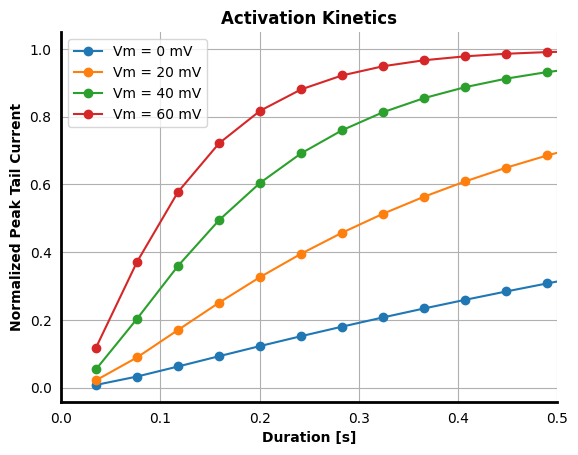

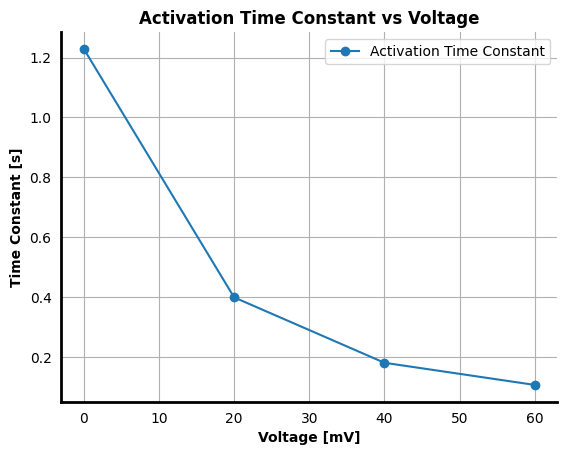

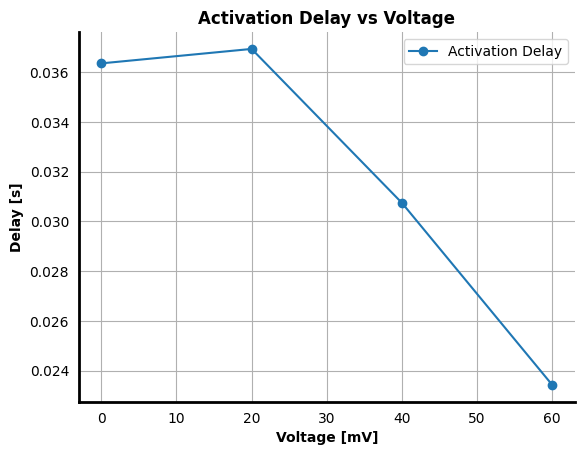

In [123]:
# ----- Parameters
Vmclamp = -80.0 # [mV]
Vmpre = np.arange(0, 61, 20) # [mV]
dpre1 = np.linspace(0.035, 0.49, 12)
dpre = np.append(dpre1, np.linspace(0.55, 10, 20))
Vmtest = np.array([-120]) # [mV] 
dtest = 0.2 # [s]
dt = 0.0001 # [s]
Ek = -82.0 # [mV]

peak_tail_currents, tauvals, delays = activation_kinetics(
    Vmclamp = Vmclamp, Vmpres = Vmpre, dpres = dpre, Vmtests = Vmtest, 
    dtest = dtest, dt = dt, Ek = Ek
    )

# ---- Plot the tail currents
for iv in range(peak_tail_currents.shape[0]):
    plt.plot(dpre[:-1], peak_tail_currents[iv, :-1], 'o-', label = f'Vm = {Vmpre[iv]} mV')
plt.xlim(0, 0.5)
plt.xlabel('Duration [s]', fontweight = 'bold')
plt.ylabel('Normalized Peak Tail Current', fontweight = 'bold')
plt.title('Activation Kinetics', fontweight = 'bold')
style_plot()
plt.legend()
plt.show()

# ---- Plot the time constants
plt.plot(Vmpre, tauvals, 'o-', label = 'Activation Time Constant')
plt.xlabel('Voltage [mV]', fontweight = 'bold')
plt.ylabel('Time Constant [s]', fontweight = 'bold')
plt.title('Activation Time Constant vs Voltage', fontweight = 'bold')
style_plot()
plt.show()

# ---- Plot the delays
plt.plot(Vmpre, delays, 'o-', label = 'Activation Delay')
plt.xlabel('Voltage [mV]', fontweight = 'bold')
plt.ylabel('Delay [s]', fontweight = 'bold')
plt.title('Activation Delay vs Voltage', fontweight = 'bold')
style_plot()
plt.show()

Above we calculate the time constants for activation. The figures are similar to figures 2B and 2C in the paper. The time constant for Vm = 0, is higher than reported in the paper somehow.

# Protocol 3: Deactivation Kinetics

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


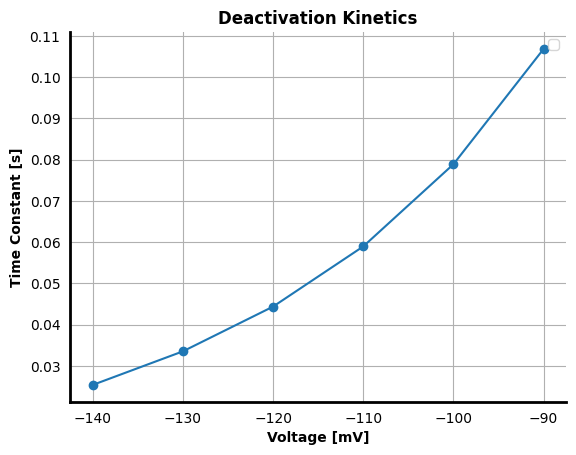

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


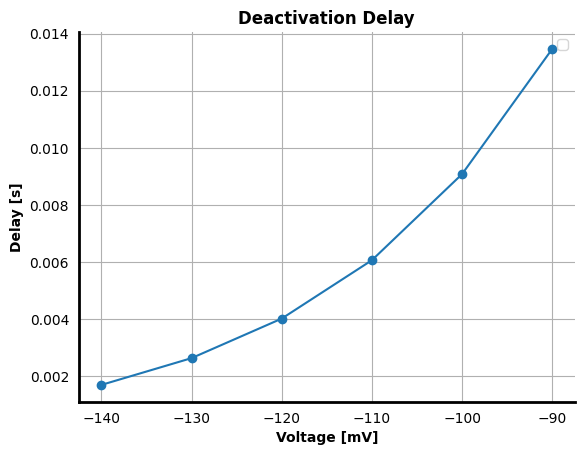

In [127]:
# ----- Parameters
Vmclamp = -80.0 # [mV]
Vmpres = np.array([60.0]) # [mV]
dpres = np.array([2.0]) # [s]
Vmtests = np.arange(-140, 41, 10) # [mV] 
dtest = 1.0 # [s]
dt = 0.0001 # [s]
Ek = -82.0 # [mV]


def deactivation_kinetics(Vmclamp: float, Vmpres: np.ndarray[np.float64], 
                          dpres: np.ndarray[np.float64], Vmtests: np.ndarray[np.float64], 
                          dtest: float, dt: float, Ek: float, Vm_tau: np.ndarray[np.float64]
                          ) -> np.ndarray[np.float64]:
    """Goal:
        This function returns the deactivation kinetics of the Kv11 channel for a given
        voltage clamp protocol.
    -----------------------------------------------------------------------------------
    Input:
        Vmclamp: Membrane voltage [mV]
        Vmpre: Voltage of the pre-pulse [mV]
        dpre: Duration(s) of the pre-pulse [s]
        Vmtest: Voltage of the test pulse [mV]
        dtest: Duration of the test pulse [s]
        dt: Time step [s]
        Ek: Potassium reversal potential [mV]
        Vm_tau: Voltage(s) for which the time constant should be calculated
    -----------------------------------------------------------------------------------
    Output:
        act_data:
            Normalized peak tail currents of the Kv11 channel for the given voltage clamp
            protocol.
        taus:
            Time constants of the deactivation kinetics of the Kv11 channel for a given 
            voltage clamp protocol.
    """
    tail_currents, act_data = get_peak_tail_currents(
        Vmclamp = Vmclamp, Vmpres = Vmpres, dpres = dpres, Vmtests = Vmtests, 
        dtest = dtest, dt = dt, Ek = Ek
    )

    taus, delays = [], []
    for v in Vm_tau:
        i = np.where(Vmtests == v)[0][0]
        argmax = np.argmax(abs(tail_currents[0, 0, i, :]))
        tail_curr_norm = tail_currents[0, 0, i, :] / tail_currents[0, 0, i, argmax]
        tail_curr_norm = tail_curr_norm[argmax:]
        t_test = np.arange(0, dtest, dt)[argmax:]

        tau, delay = get_tau(tail_curr_norm[None, :], t_test, label = "deactivation kinetics",
                             plot = False)
        taus.append(tau[0])
        delays.append(delay[0])

    return act_data, taus, delays

Vm_tau = [-140, -130, -120, -110, -100, -90]
act_data, taus, delays = deactivation_kinetics(
    Vmclamp, Vmpres, dpres, Vmtests, dtest, dt, Ek, Vm_tau
    )

plt.plot(Vm_tau, taus, 'o-')
plt.xlabel('Voltage [mV]', fontweight = 'bold')
plt.ylabel('Time Constant [s]', fontweight = 'bold')
plt.title('Deactivation Kinetics', fontweight = 'bold')
style_plot()
plt.show()

plt.plot(Vm_tau, delays, 'o-')
plt.xlabel('Voltage [mV]', fontweight = 'bold')
plt.ylabel('Delay [s]', fontweight = 'bold')
plt.title('Deactivation Delay', fontweight = 'bold')
style_plot()
plt.show()

# tau = act_tau(tail_currents[0, 0, :, :], np.arange(0, dtest, dt))
# plt.plot(Vmtests, tau, 'o-')
# plt.xlabel('Voltage [mV]', fontweight = 'bold')
# plt.ylabel('Time Constant [s]', fontweight = 'bold')
# plt.title('Activation Kinetics', fontweight = 'bold')
# style_plot()
# plt.show()

# plt.plot(Vmtests, act_data[0, 0, :], "o-")
# plt.xlabel('Voltage [mV]', fontweight = 'bold')
# plt.ylabel('Normalized Peak Tail Current', fontweight = 'bold')
# plt.title('Deactivation Kinetics', fontweight = 'bold')
# style_plot()
# plt.show()
